<a href="https://colab.research.google.com/github/AlexMourao19/CAPCHA_Decoding/blob/main/CAPCHA_Decoding_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Assignment 2: Captcha Decoding</b></h1>
<p>Computer Vision 2022/2023</p>
<b>Alexandre Mourão</b> & <b>Pedro Duarte</b>

---

# Introdução

O presente relatório tem como finalidade apresentar as atividades desenvolvidas e os resultados obtidos ao longo do segundo trabalho laboratorial realizado no âmbito da unidade curricular Visão por Computador.

O objetivo deste projeto passava por desenvolver uma Rede Neuronal Convolucional (CNN) capaz de descodificar imagens CAPTCHA (*Completely Automated Public Touring test to Tell Computers and Humans Apart*) com 4 ou 5 caracteres. Desse modo, foi necessário projetar o modelo da CNN, implementá-lo e treiná-lo. Seguidamente, procedeu-se à avaliação do desempenho do modelo desenvolvido, tendo-se considerado diferentes métricas de avaliação.

# Metodologia

Esta secção demonstra as diferentes etapas no desenvolvimento da rede neuronal, como a criação do modelo e a definição de funções de teste e treino, sem esquecer o processamento das imagens e a criação do dataset.

In [ ]:
!pip install patool
!gdown https://drive.google.com/uc?id=1TQx-bRo6O3yum6zP3DfD7-sQItt02iNh
import patoolib
patoolib.extract_archive("CAPTCHA_dataset.rar")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 5.8 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1TQx-bRo6O3yum6zP3DfD7-sQItt02iNh
To: /content/CAPTCHA_dataset.rar
100% 116M/116M [00:01<00:00, 70.4MB/s]
patool: Extracting CAPTCHA_dataset.rar ...
patool: running /usr/bin/unrar x -- /content/CAPTCHA_dataset.rar
patool:     with cwd='./Unpack_44y3v1r8'
patool: ... CAPTCHA_dataset.rar extracted to `CAPTCHA_dataset'.


'CAPTCHA_dataset'

### Processamento de Imagem

Antes de se desenvolver a rede neuronal, decidiu-se primeiramente fazer o pré-processamento das imagens disponibilizadas, pois estas contêm sempre algum tipo de ruído, e este processamento tem o objetivo de fazer com que os caracteres sejam mais legíveis pela rede neuronal.

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import random
import matplotlib.pyplot as plt

soft_train_path = '/content/CAPTCHA_dataset/soft/train'
soft_test_path = '/content/CAPTCHA_dataset/soft/test'
hard_train_path = '/content/CAPTCHA_dataset/hard/train'
hard_test_path = '/content/CAPTCHA_dataset/hard/test'

Começou-se por passar a imagem original para "grayscale", e de seguida aplicou-se um close (dilate seguido de um erode), para eliminar a maior parte do ruído da imagem, bem como as linhas indesejadas do dataset *hard* providenciado. De seguida, foi aplicado a função "clahe" para melhorar os contrastes das letras com o fundo e de seguida um threshold adaptativo para binarizar a imagem. O passo seguinte foi limitar aquilo que era ou não passado para a imagem, utilizando-se a função "connectedComponentsWithStats" para impedir que algum ruído residual fosse apanhado, para isso usou-se um threshold na área destes "connectedComponents".

É de notar que anteriormente se usou uma binarização inversa, isto deve-se a este seguinte passo, que foi usar a função "findContours", sendo assim possível identificar cada letra em separado, e por sua vez separar o captcha por letra, sendo o resultado desta função um vetor com todas as imagens do captcha separadas.

Foi feita uma função auxiliar "imagem_resize" para fazer com que todas estas imagens tivessem o mesmo tamanho, caso sejam menores que o tamanho desejado introduziu-se espaço em preto, isto foi feito pois o dataset da rede neuronal exige imagens todas com o mesmo tamanho.

In [ ]:
# funcao para criar uma imagem com cada caracter separado
def imagem_resize(imagens):
    height = 77
    width = 59

    imagens_redimensionadas = []
    for img in imagens:
        if img.shape[1] > width:
          # Redimensionar a imagem para a largura desejadaz
          img = cv2.resize(img, (width, height))

        img_redimensionada = cv2.resize(img, (img.shape[1], height))
        dif_largura = width - img_redimensionada.shape[1]
        padding_esquerda = dif_largura // 2
        padding_direita = dif_largura - padding_esquerda
        img_redimensionada = cv2.copyMakeBorder(img_redimensionada, top=0, bottom=0, left=padding_esquerda, right=padding_direita, borderType=cv2.BORDER_CONSTANT, value=0)
        imagens_redimensionadas.append(img_redimensionada)

    return imagens_redimensionadas

In [ ]:
# for filename in selected_files:
def processamentoImagem(filepath):
    img = cv2.imread(filepath)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Close
    kernel1 = np.ones((4, 2), 'uint8')
    kernel2 = np.ones((2, 1), 'uint8')
    img_processada = cv2.dilate(img_gray, kernel1, iterations=1)
    img_processada = cv2.erode(img_processada, kernel2, iterations=1)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_processada)

    binary = cv2.adaptiveThreshold(clahe_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    binary = cv2.bitwise_not(binary)

    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(binary)
    areas = stats[:, cv2.CC_STAT_AREA]
    area_threshold = 100
    binary_clean = np.where(np.isin(labels_im, np.where(areas < area_threshold)), 0, binary)

    # Contours
    contours, hierarchy = cv2.findContours(binary_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    image_copy = img_processada.copy()

    segmented_images = []
    i = 0
    for i, cnt in enumerate(contours):
      x, y, w, h = cv2.boundingRect(cnt)
      image = binary_clean[y:y+h, x:x+w]
      segmented_images.append(image)

    imagens_seg = imagem_resize(segmented_images)

    return imagens_seg

In [ ]:
# retorna o texto do nome da imagem
def captcha_text(filename):
  filename = os.path.basename(filename)
  captcha_text = os.path.splitext(filename)[0]
  return captcha_text

Esta seguinte função não era pedida, mas decidiu-se mantê-la, pois com ela foi possível experimentar várias técnicas, bem como alterar as técnicas já usadas (ex: mudar os kernels do dilate e do erode) até a precisão máxima ser alcançada em ambos os datasets disponibilizados.
Note-se que aqui a precisão é apenas calculada usando o número de imagens que se conseguiu separar nas funções feitas anteriormente e o número suposto de letras no captcha.

In [ ]:
path = soft_train_path
png_files = [file for file in os.listdir(path) if file.endswith('.png')]
random_files = random.sample(png_files, 1)

nr_total = 0
nr_failed = 0

heights = []
widths = []

for file in png_files:
  # Construct the full file path
  file_path = os.path.join(path, file)
  text = captcha_text(file)
  segments = processamentoImagem(file_path)
  nr_total += 1
  #cv2_imshow(comp)

  expected_len = len(os.path.splitext(file)[0])
  if expected_len != len(segments):
     nr_failed += 1

accuracy = (1 - nr_failed/nr_total) * 100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 91.34%


### Dataset

Estes seguintes trechos de código têm como objetivo criar um dataset para a rede neuronal ler.

In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transforms
import torchvision
from sklearn.preprocessing import LabelEncoder
import pandas as pd

Para tal, em primeira instância fez-se uma função que recebe o caminho para as imagens e a sua utilização. Dependendo da sua utilização, cria pastas para depositar os dados e, com o auxílio das funções criadas no processamento de imagem, separa o captcha por caractere e introduz estas numa nova pasta, cria postriormente uma tabela em pandas onde está guardado o caminho destas letras bem como o caractere a que cada imagem corresponde.

In [ ]:
def processedDataset(dir_path, tipo):
    data = []
    i = 0

    if tipo == "captcha":
        file = os.path.basename(dir_path)
        text = captcha_text(file)
        segments = processamentoImagem(dir_path)

        output_folder = "/content/letras/captcha_path"

        if not os.path.exists(output_folder):
              os.makedirs(output_folder)
        letters = list(text)

        for letter, segment in zip(letters, segments):
              output_path = os.path.join(output_folder, f"imagem_{i}.png")
              cv2.imwrite(output_path, segment)
              data.append({
                  'Path_Image': output_path,
                  'Character': letter
              })
              i = i + 1
        df = pd.DataFrame(data)
        return df

    else:
        png_files = [file for file in os.listdir(dir_path) if file.endswith('.png')]
        for file in png_files:
            file_path = os.path.join(dir_path, file)
            text = captcha_text(file)
            segments = processamentoImagem(file_path)

            match (tipo):
              case ("soft_train"):
                  output_folder = "/content/letras/soft/train"
              case ("soft_test"):
                  output_folder = "/content/letras/soft/test"
              case ("hard_train"):
                  output_folder = "/content/letras/hard/train"
              case ("hard_test"):
                  output_folder = "/content/letras/hard/test"

            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            letters = list(text)
            for letter, segment in zip(letters, segments):

                output_path = os.path.join(output_folder, f"imagem_{i}.png")
                cv2.imwrite(output_path, segment)
                data.append({
                    'Path_Image': output_path,
                    'Character': letter
                })
                i = i + 1
        df = pd.DataFrame(data)
        return df

In [ ]:
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             ])
tfms = get_transforms()

Este código define uma classe de conjunto de dados personalizada para lidar com as imagens. A sua implementação permite que um conjunto de dados de imagem seja lido a partir de um arquivo CSV.

A classe MyImageDataset tem três funções principais:

**__init__**(self, csv_file, transform=None): Este é o construtor da classe. Inicializa o objeto com o arquivo CSV que cria as "annotations" (que contém o "path" para cada imagem, e os caracteres correspondentes). Este método também codifica as labels (neste caso, "Character") dos dados usando LabelEncoder.

**__len__**(self): Este método retorna o tamanho do conjunto de dados, ou seja, o número de imagens disponíveis.

**__getitem__**(self, index): Este método é usado para acessar uma imagem específica e seu rótulo correspondente. Ele lê a imagem a partir do caminho da imagem dado, realiza a transformação e retorna a imagem junto com a label correspondente.

In [ ]:
from sklearn.preprocessing import LabelEncoder
class MyImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.annotations['Character'])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image_path = self.annotations.loc[index, 'Path_Image']
        image = Image.open(image_path)
        label = self.label_encoder.transform([self.annotations.loc[index, 'Character']])[0]
        if self.transform:
            image = self.transform(image)

        return image, label

### Rede Neuronal Convolucional

O objetivo desta etapa do projeto passava por desenvolver uma rede neuronal convolucional capaz de descodificar imagens CAPTCHA com 4 ou 5 caracteres. Para isso, fez-se uso do PyTorch, tendo sido necessário importar as bibliotecas que se seguem.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

O procedimento seguinte foi definir a arquitetura da rede neuronal. O modelo é composto por várias camadas diferentes, nomeadamente duas camadas de convolução, cada uma delas seguida por uma camada de pooling, e duas camadas lineares, com uma função de ativação ReLU (*rectified linear unit*) após cada uma das camadas convolucionais e a primeira camada linear. Antes das camadas lineares os dados são achatados.

*   As camadas de convolução servem para identificar características na imagem. A primeira camada convolucional com 16 canais de saída aprende características mais simples e de baixo nível, como bordas e texturas básicas. Já a segunda camada convolucional com 32 canais de saída tem uma capacidade maior de aprender características mais complexas e abstratas.

*   A função ReLU ajuda a introduzir não-linearidade e está relacionada com a capacidade de discriminação do modelo. Quando os valores negativos são mapeados para zero, os neurónios correspondentes não contribuem para a ativação da camada seguinte. Isto conduz a uma maior esparsidade nas ativações, pois apenas as características relevantes e ativadas positivamente são propagadas adiante.

*   A camada de pooling reduz para metade a dimensão espacial das características de entrada.

*  As duas camadas lineares servem para realizar a classificação.

Esta arquitetura de rede convolucional mostra-se adequada para classificar imagens em 36 classes diferentes (10 dígitos e 26 letras minúsculas), assumindo que as imagens de entrada têm apenas um canal e que correspondem a um caracter.

In [ ]:
# Define the neural network architecture
class CNN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_inputs, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(17 * 13 * 64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the number of inputs and outputs
num_inputs = 1  # One character image at a time (1 channel)
num_outputs = 36  # 10 digits + 26 lowercase letters

# Create an instance of the model
model = CNN(num_inputs, num_outputs)

### Treino do modelo

Posteriormente, o foco passou para o treino do modelo desenvolvido. O objetivo principal deste processo é reduzir o valor da função de perda por meio da alteração dos valores do vetor de pesos através da retropropagação em redes neuronais, melhorando a sua capacidade de fazer previsões precisas.

Com isso em mente, verificou-se se havia uma GPU disponível de modo a acelerar a eficiência computacional.

In [ ]:
# Push model to device. Has to be only done once
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

# Convert model parameters and buffers to CPU or CUDA
model.to(device)

The model will be running on cuda:0 device


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=14144, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=36, bias=True)
)

De seguida, definiram-se alguns hiperparâmetros essenciais no desenvolvimento, treino e teste do modelo.

In [ ]:
# Define some hyperparameters
learning_rate = 0.001
num_epochs = 20 #40
batch_size_train = 144
batch_size_test = 36

##### **Otimização**

Utilizou-se a CrossEntropyLoss como função de perda por se tratar de um problema de classificação multiclasse. O otimizador escolhido foi o algoritmo Adam.

In [ ]:
# Define the loss function
loss_module = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### **Loop de Treino**

Para treinar o modelo, primeiro foi necessário preparar os dados para serem utilizados pelo modelo, quer o soft dataset como o hard dataset, com recurso às funções desenvolvidas anteriormente.

In [ ]:
# Soft dataset
trainset_soft = processedDataset(soft_train_path, "soft_train")
trainset_soft.to_csv('/content/soft_train.csv', index=True)

train_dataset_soft = MyImageDataset("soft_train.csv", transform=transforms.ToTensor())
train_data_loader_soft = DataLoader(train_dataset_soft, batch_size_train, shuffle=True)

# Hard dataset
trainset_hard = processedDataset(hard_train_path, "hard_train")
trainset_hard.to_csv('/content/hard_train.csv', index=True)

train_dataset_hard = MyImageDataset("hard_train.csv", transform=transforms.ToTensor())
train_data_loader_hard = DataLoader(train_dataset_hard, batch_size_train, shuffle=True)

Posto isto, partiu-se para o desenvolvimento do modelo de treino.

In [ ]:
from tqdm.notebook import trange, tqdm

def train_model(model, optimizer, data_loader, loss_criteria, num_epochs):

    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):

        train_acc = 0.0
        train_loss = 0.0

        for data_inputs, data_labels in data_loader:

            # Move input data to device (needed in case of GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # Setting gradients to zero. The gradients would not be overwritten but actually added to the existing ones.
            optimizer.zero_grad()

            # Run the model on the input data
            y_pred = model(data_inputs)
            y_pred = y_pred.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            # Calculate the loss
            loss = loss_criteria(y_pred, data_labels)

            # Perform backpropagation
            loss.backward()

            # Update parameters based on the calculated gradients
            optimizer.step()

            # Take the running average of the loss
            train_loss += loss.item()

            # Calculate and accumulate accuracy metric across all batches
            pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (pred_labels == data_labels).sum().item() / len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)

        print(f"[{epoch + 1}] Loss: {train_loss:.3f} | Accuracy: {100*train_acc:.2f} %")

### Teste do modelo

O objetivo desta fase é avaliar o desempenho do modelo que foi previamente treinado. Assim, foi novamente necessário preparar os dados.

In [ ]:
# Soft dataset
testset_soft = processedDataset(soft_test_path, "soft_test")
testset_soft.to_csv('/content/soft_test.csv', index=True)

test_dataset = MyImageDataset("soft_test.csv", transform=transforms.ToTensor())
test_data_loader_soft = DataLoader(test_dataset, batch_size_test, shuffle=False)

# Hard dataset
testset_hard = processedDataset(hard_test_path, "hard_test")
testset_hard.to_csv('/content/hard_test.csv', index=True)

test_dataset_hard = MyImageDataset("hard_test.csv", transform=transforms.ToTensor())
test_data_loader_hard = DataLoader(test_dataset_hard, batch_size_test, shuffle=False)

Posto isto, desenvolveu-se o modelo de teste, que retorna as previsões do modelo e as respostas corretas em tensores.

In [ ]:
def eval_model(model, data_loader):
    # Set model to eval mode
    model.eval()

    test_acc = 0.0
    true_preds, num_preds = 0., 0.
    pred_labels = []
    true_labels = []

    # Deactivate gradients for the following code
    with torch.no_grad():
        # Get batch of images from the test DataLoader
        for data_inputs, data_labels in data_loader:

            # Move input data to device (needed in case of GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # Determine prediction of model
            y_pred = model(data_inputs)
            y_pred = y_pred.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Get the index of the predicted class with the highest probability
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (y_pred_class == data_labels).sum()
            num_preds += data_labels.shape[0]

            pred_labels.extend(y_pred_class.tolist())
            true_labels.extend(data_labels.tolist())

    test_acc = true_preds / num_preds

    print(f"Accuracy of the model: {100*test_acc:4.2f}%")

    return pred_labels, true_labels

# Resultados

Esta secção é dedicada à apresentação dos resultados obtidos durante as fases de treino e de teste, sendo que se utilizaram ambos os *datasets* disponíveis (*soft* e *hard*) para obter melhores resultados. Além disso, procedeu-se ao cálculo da *confusion matrix* com os dados resultantes do teste.

Em primeiro lugar, treinou-se o modelo desenvolvido com recurso ao *soft dataset*.

In [ ]:
train_model(model, optimizer, train_data_loader_soft, loss_module, num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

[1] Loss: 1.303 | Accuracy: 68.35 %
[2] Loss: 0.697 | Accuracy: 84.09 %
[3] Loss: 0.588 | Accuracy: 86.64 %
[4] Loss: 0.527 | Accuracy: 88.33 %
[5] Loss: 0.483 | Accuracy: 89.43 %
[6] Loss: 0.444 | Accuracy: 90.31 %
[7] Loss: 0.418 | Accuracy: 90.85 %
[8] Loss: 0.391 | Accuracy: 91.41 %
[9] Loss: 0.372 | Accuracy: 91.63 %
[10] Loss: 0.358 | Accuracy: 91.84 %
[11] Loss: 0.333 | Accuracy: 92.40 %
[12] Loss: 0.316 | Accuracy: 92.70 %
[13] Loss: 0.299 | Accuracy: 93.01 %
[14] Loss: 0.291 | Accuracy: 92.87 %
[15] Loss: 0.273 | Accuracy: 93.10 %
[16] Loss: 0.262 | Accuracy: 93.32 %
[17] Loss: 0.254 | Accuracy: 93.37 %
[18] Loss: 0.243 | Accuracy: 93.69 %
[19] Loss: 0.228 | Accuracy: 93.77 %
[20] Loss: 0.219 | Accuracy: 94.01 %


A evolução da perda e da *accuracy* durante o treino do modelo foi acompanhada ao longo das épocas. Observou-se que a perda diminuiu gradualmente ao longo do tempo, indicando que o modelo aprendeu a identificar os padrões mais simples nos dados. Conforme o treino foi progredindo, a taxa de melhoria diminuiu, indicando o ajuste do modelo para padrões mais complexos. Por outro lado, a *accuracy* aumentou gradualmente ao longo do tempo, como era de esperar.

No entanto, a ocorrência de *overfitting* pode ser uma preocupação, já que a perda atingiu valores muito baixos e a *accuracy* valores muito altos. Para lidar com esse problema, poderiam ser aplicadas técnicas de regularização, como *dropout*.

Posto isto, testou-se o modelo com os dados de teste do *soft dataset*.

In [ ]:
pred_labels_soft, data_labels_soft = eval_model(model, test_data_loader_soft)

Accuracy of the model: 90.98%


A *accuracy* obtida com o teste mostrou-se bastante inferior à resultante do treino, o que, mais uma vez, pode indicar *overfitting*. Esta diferença sugere que o modelo pode não estar a generalizar-se bem para exemplos fora do conjunto de treino, ao memorizar o conjunto de treino em vez de aprender padrões gerais.

De seguida, treinou-se novamente o modelo, desta vez com o conjunto de treino do *hard dataset*.

In [ ]:
train_model(model, optimizer, train_data_loader_hard, loss_module, num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

[1] Loss: 0.514 | Accuracy: 89.78 %
[2] Loss: 0.408 | Accuracy: 91.54 %
[3] Loss: 0.368 | Accuracy: 92.21 %
[4] Loss: 0.336 | Accuracy: 92.56 %
[5] Loss: 0.314 | Accuracy: 92.91 %
[6] Loss: 0.287 | Accuracy: 93.29 %
[7] Loss: 0.269 | Accuracy: 93.56 %
[8] Loss: 0.247 | Accuracy: 93.68 %
[9] Loss: 0.227 | Accuracy: 94.08 %
[10] Loss: 0.214 | Accuracy: 94.16 %
[11] Loss: 0.204 | Accuracy: 94.37 %
[12] Loss: 0.192 | Accuracy: 94.53 %
[13] Loss: 0.178 | Accuracy: 94.75 %
[14] Loss: 0.170 | Accuracy: 94.84 %
[15] Loss: 0.159 | Accuracy: 95.06 %
[16] Loss: 0.149 | Accuracy: 95.34 %
[17] Loss: 0.144 | Accuracy: 95.49 %
[18] Loss: 0.136 | Accuracy: 95.51 %
[19] Loss: 0.128 | Accuracy: 95.74 %
[20] Loss: 0.125 | Accuracy: 95.77 %


Como era de esperar, o modelo apresenta-se um pouco pior a início, por os dados serem mais desafiantes. Contudo, com o decorrer do tempo, os valores atingem novamente valores muito extremos, indicando novamente *overfitting*.

O modelo treinado foi testado com o conjunto de teste do *hard dataset*.

In [ ]:
pred_labels_hard, data_labels_hard = eval_model(model, test_data_loader_hard)

Accuracy of the model: 91.20%


O resultado da *accuracy* mostra-se semelhante ao obtido no teste anterior, apesar dos caracteres serem mais difíceis de prever, o que pode indicar uma melhoria de desempenho. Novamente verifica-se uma grande diferença entre as *accuracy* do treino e do teste.

### Confusion matrix

Com os teste realizados e a *accuracy* calculada, o próximo passo foi obter as *confusion matrix* para os dois testes realizados, com o intuito de perceber quais classes o modelo prevê corretamente e quais classes estão sendo confundidas. Assim, começou-se por definir a função *plot_confusion_matrix()* para imprimir as matrizes.

In [ ]:
import string
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define classes
digits = string.digits  # '0' to '9'
lowercase_letters = string.ascii_lowercase  # 'a' to 'z'
classes = list(digits + lowercase_letters)
print(classes)

def plot_confusion_matrix(data_labels, pred_labels):
    fig = plt.figure(figsize=(36, 36))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(data_labels, pred_labels)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Confusion matrix do teste com soft dataset:

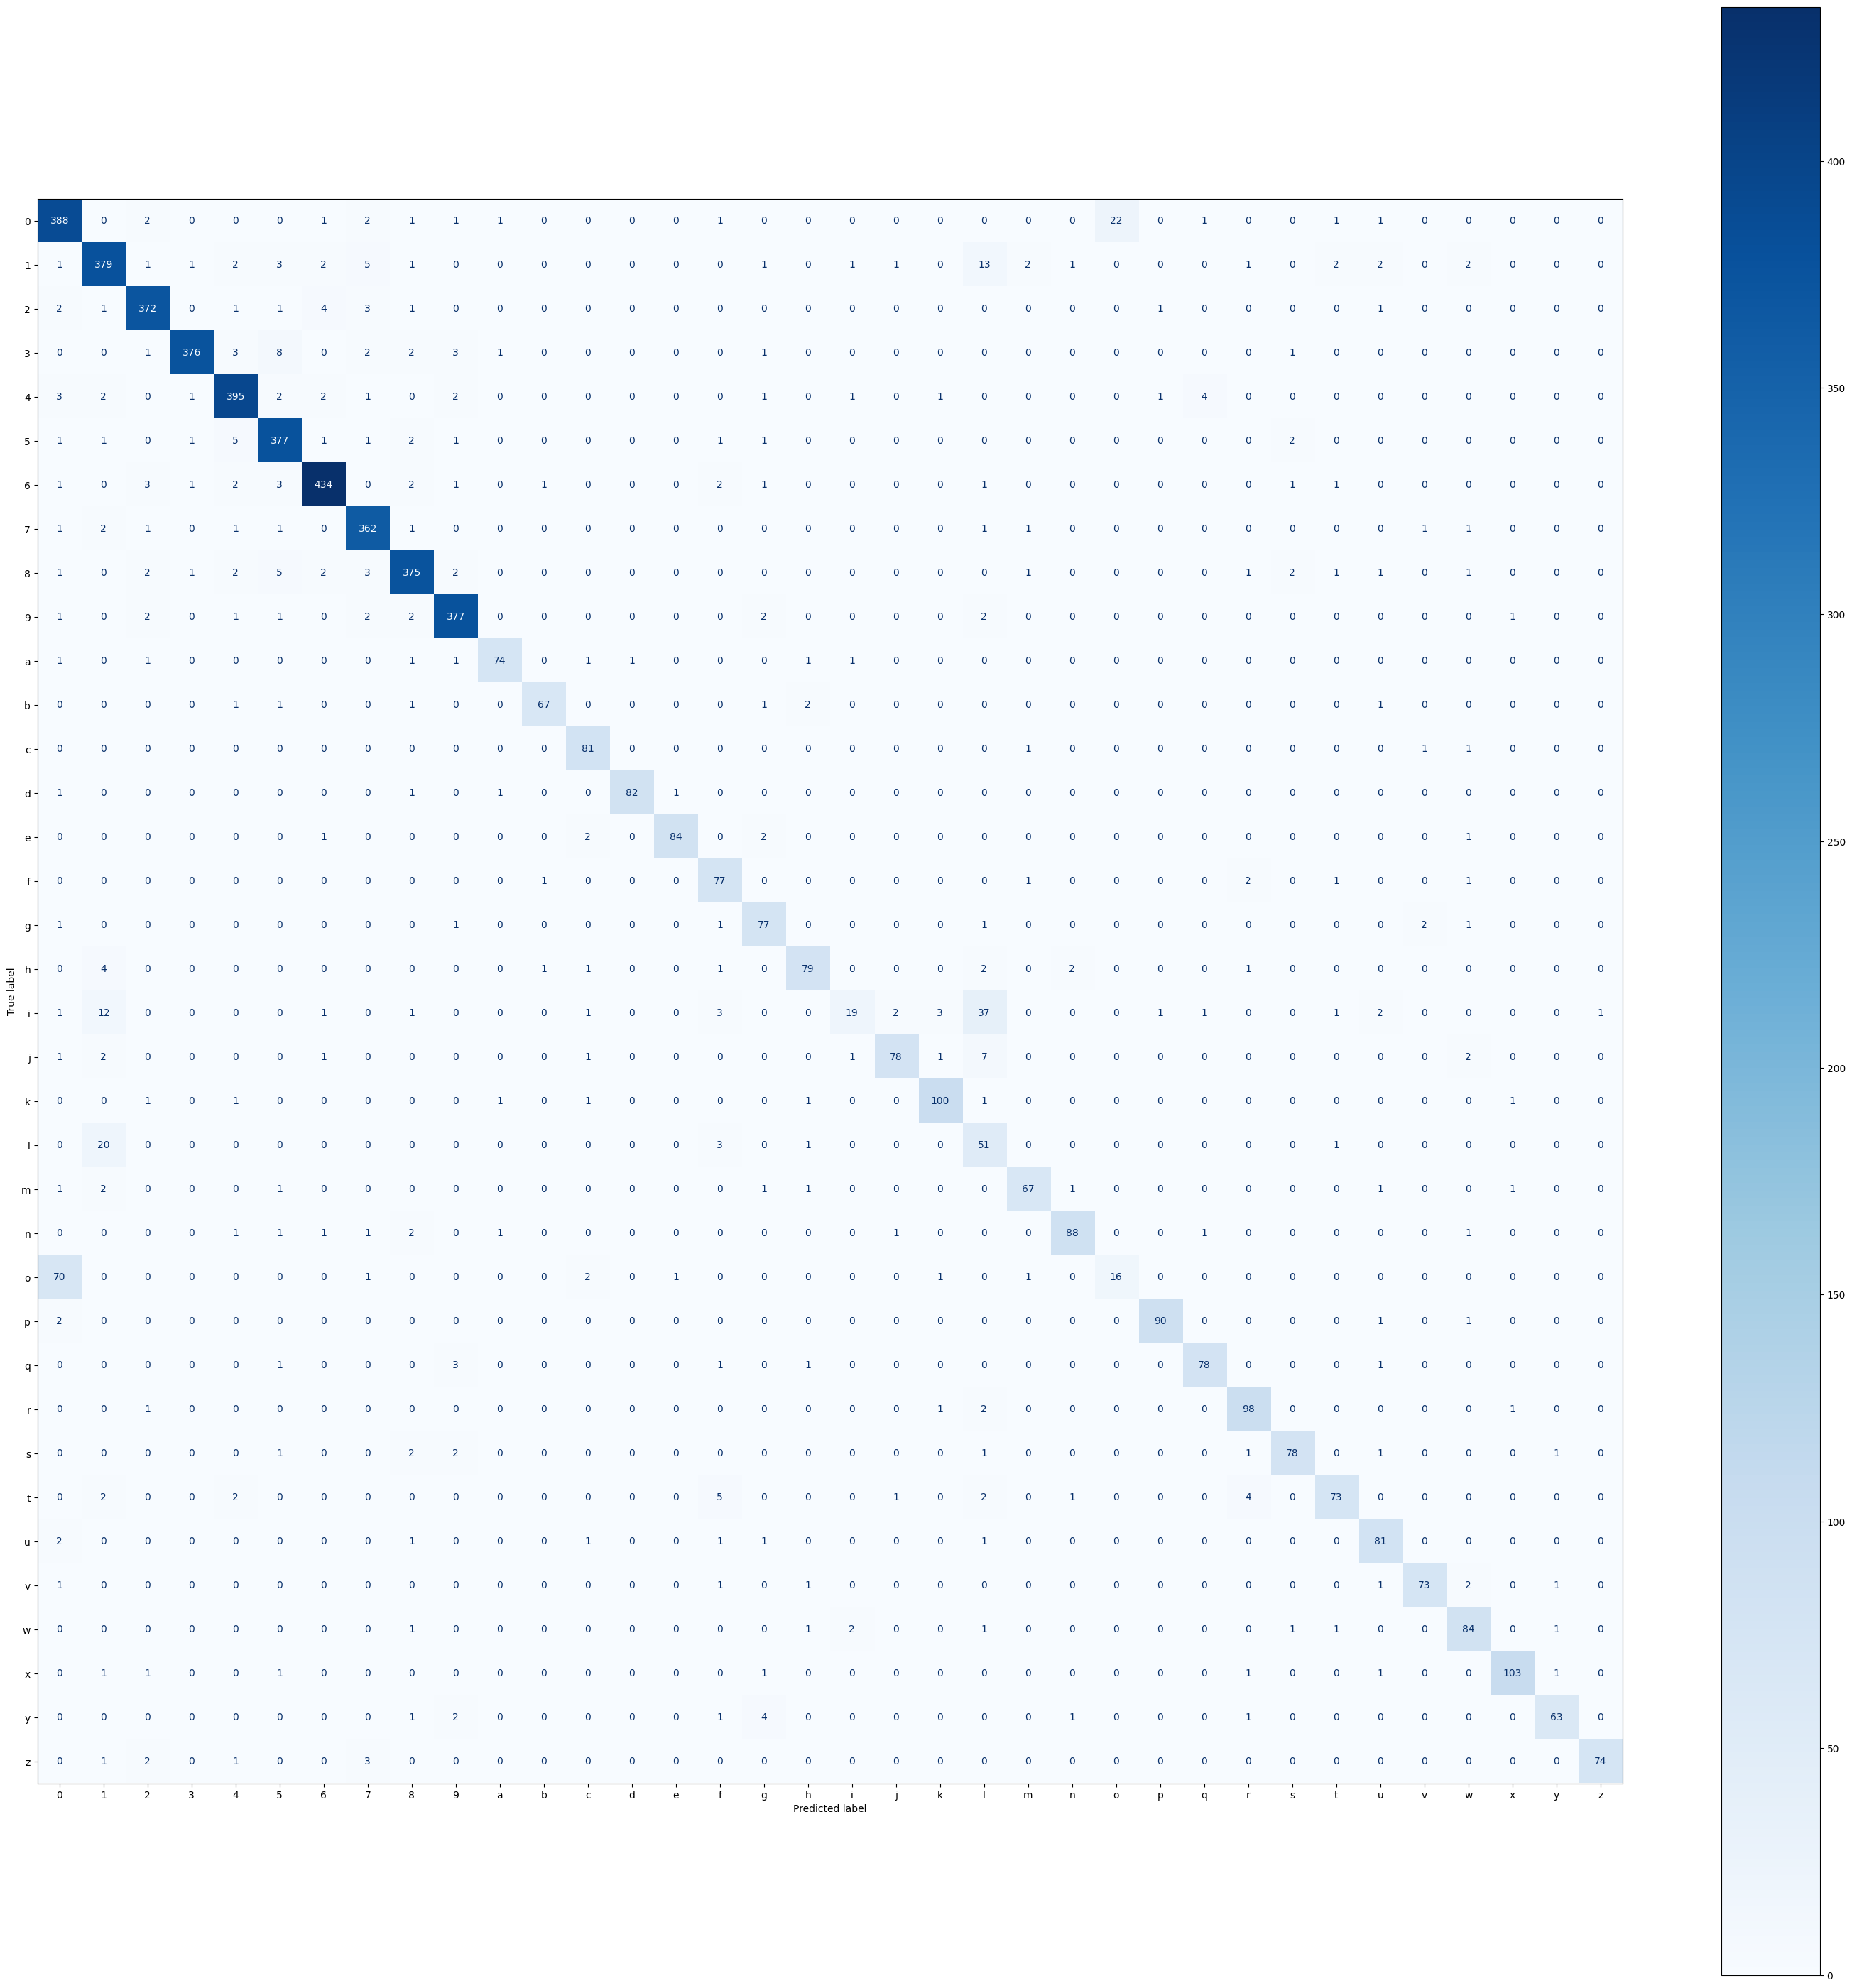

In [ ]:
plot_confusion_matrix(np.array(data_labels_soft), np.array(pred_labels_soft))

Confusion matrix do teste com hard dataset:

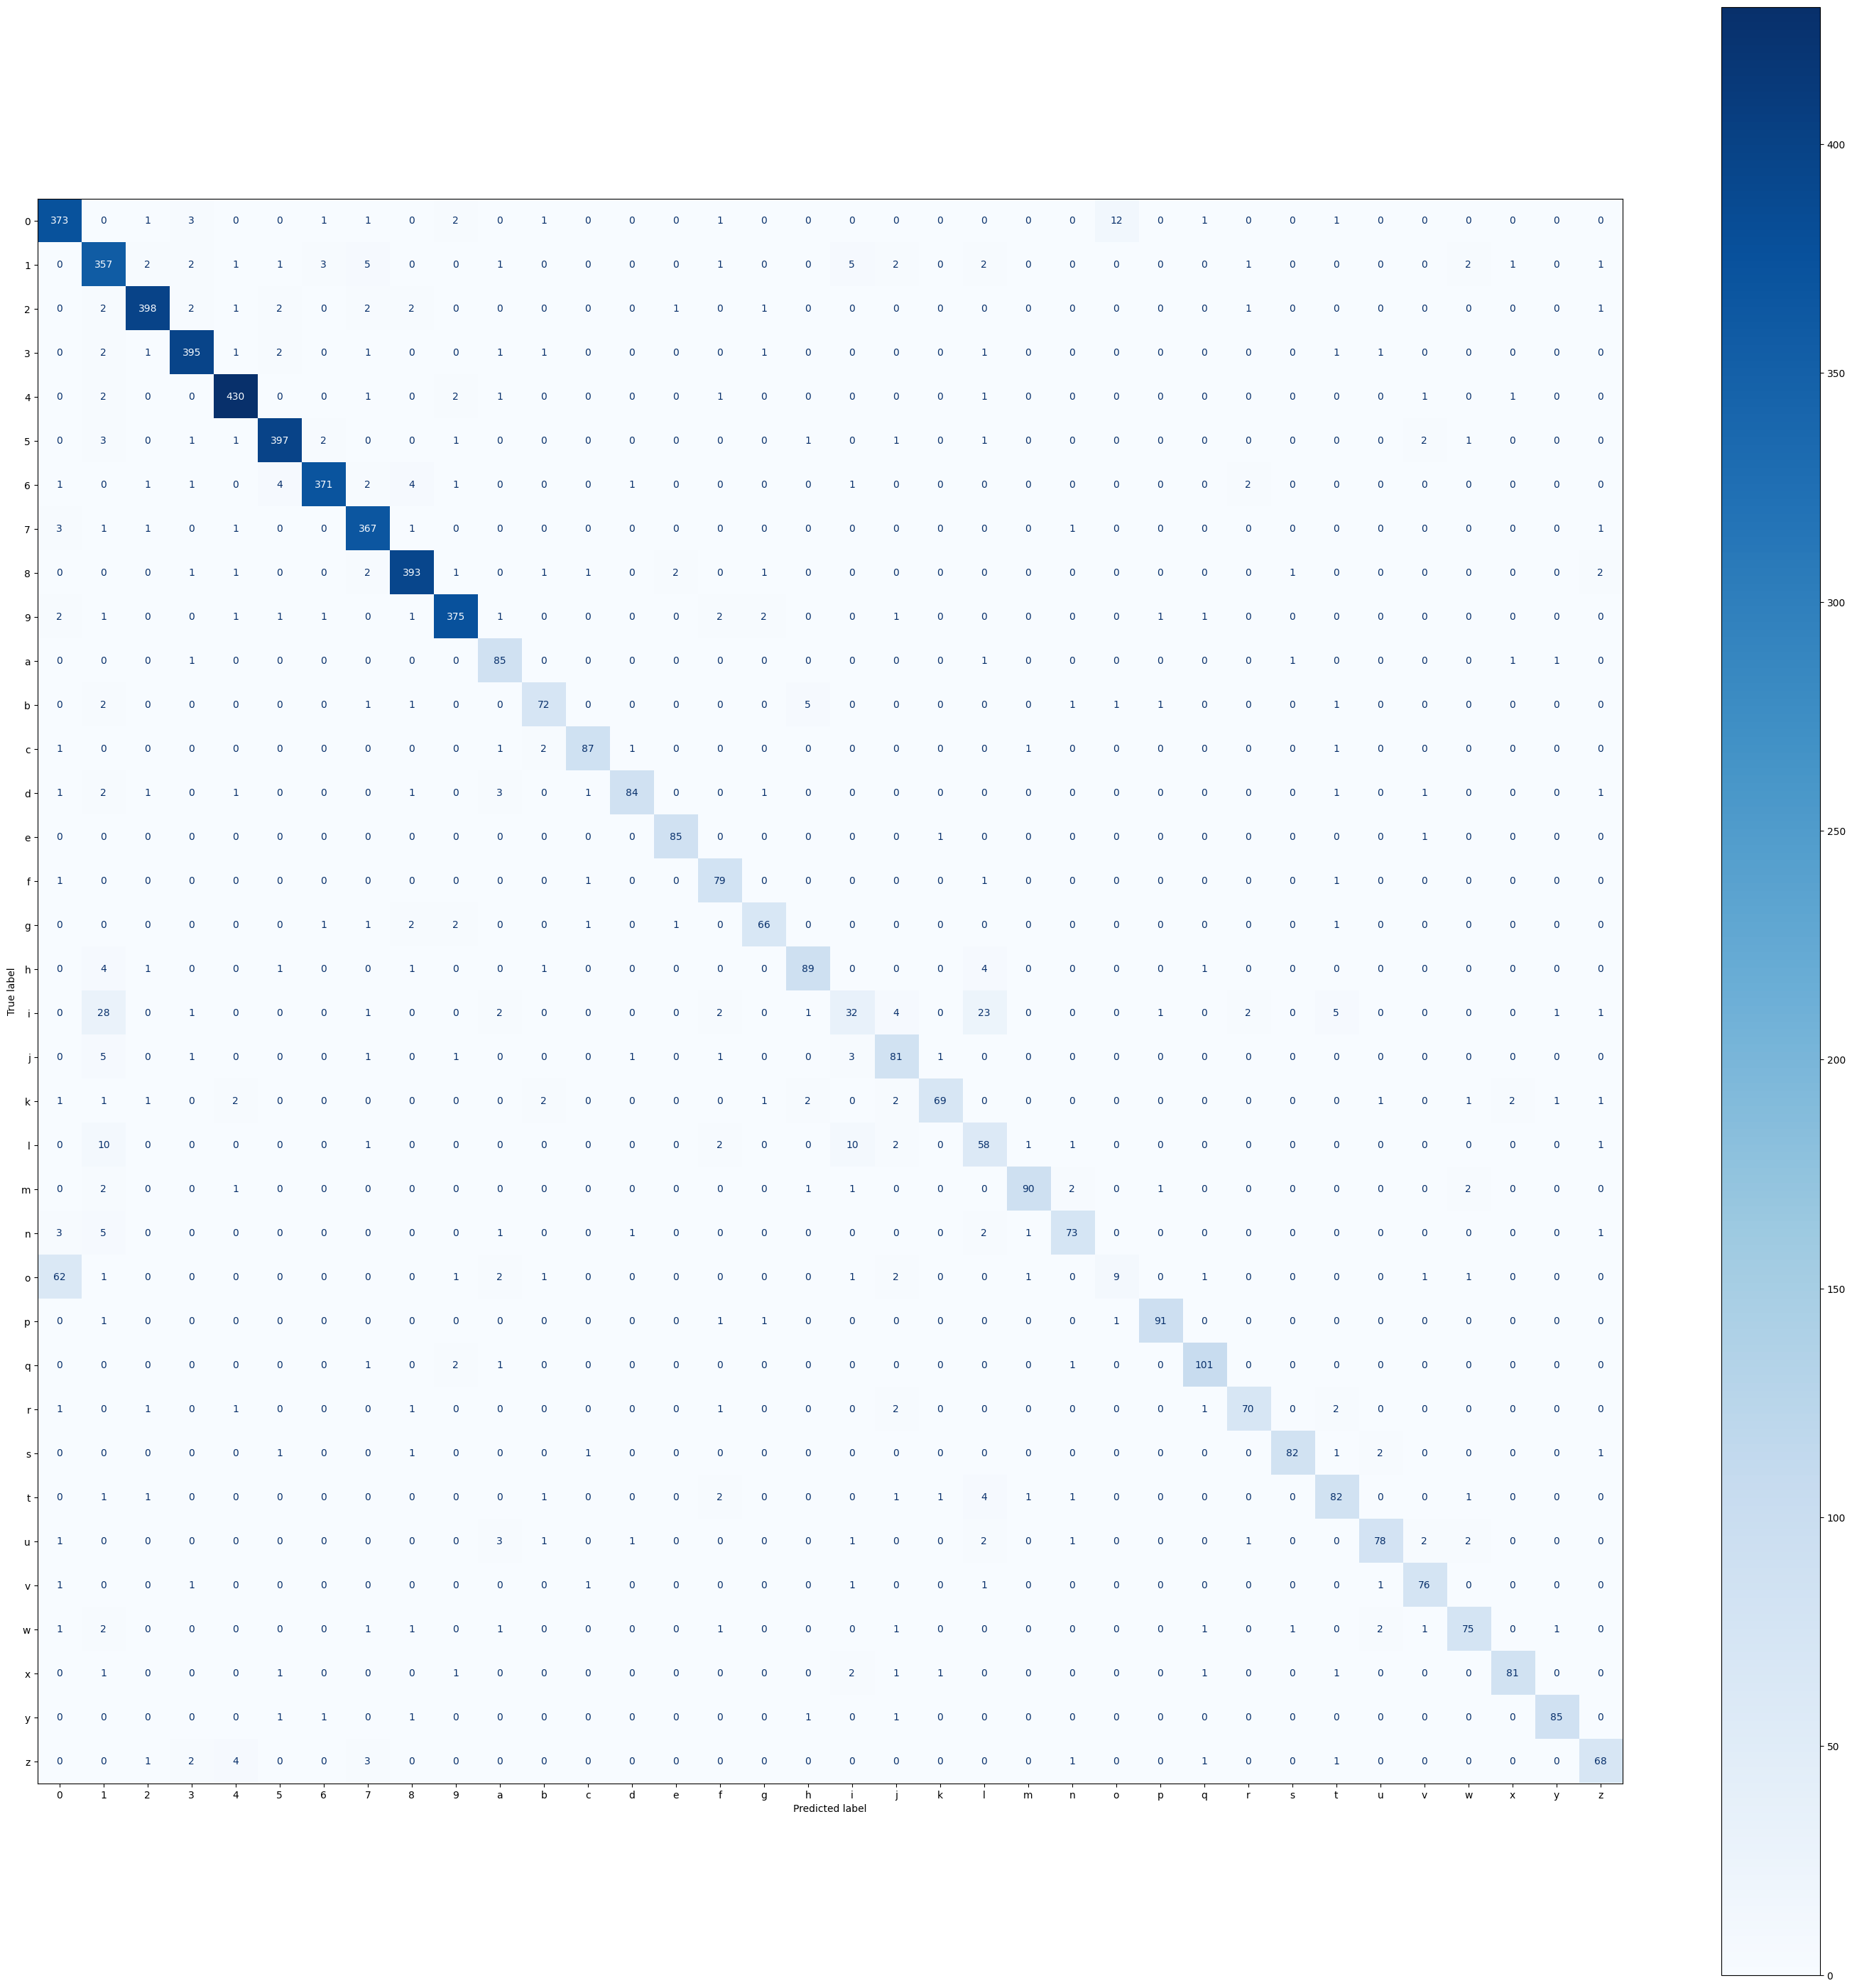

In [ ]:
plot_confusion_matrix(np.array(data_labels_hard), np.array(pred_labels_hard))

Os resultados obtidos confirmam o que tinha sido concluído após o cálculo da accuracy, nomeadamente que, no geral, o modelo é capaz de prever com bastante precisão os caracteres na imagem CAPTCHA. Denota-se, no entanto, a existência de alguns pares de caracteres que têm mais tendência para ser confundidos; de salientar o caso do '0' e do 'o', que sobressai sobre os demais.

# Demonstração do modelo CNN desenvolvido

O modelo desenvolvido recebe como entrada apenas um caractere de cada vez. Por esse motivo, criou-se esta secção para demonstrar como utilizar o modelo desenvolvido para descodificar uma imagem CAPTCHA com 4 ou 5 caracteres.

Começou-se por salvar o modelo para posterior utilização.

In [ ]:
# Save the model
model_path = '/content/model.h5'
torch.save(model.state_dict(), model_path)

print("Modelo salvo com sucesso em:", model_path)

NameError: ignored

Posto isto, foi possível carregar o modelo.

In [ ]:
# Load the saved model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Escolheu-se uma imagem aleatória para exemplo a partir do conjunto de teste do *hard dataset*. Os dados de entrada tiveram de ser preparados para serem utilizados pelo modelo.

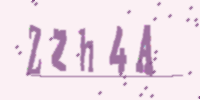

In [ ]:
import random

# Specify the path to the folder containing the images
folder_path = '/content/CAPTCHA_dataset/hard/test'

# Choose a random image from the list
list_captcha_path = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png')]
captcha_path = random.choice(list_captcha_path)

# Load the image and display image
captcha = cv2.imread(captcha_path)
cv2_imshow(captcha)

captchaset = processedDataset(captcha_path, "captcha")
captchaset.to_csv('/content/captcha.csv', index=True)

captcha_dataset = MyImageDataset("captcha.csv", transform=transforms.ToTensor())
captcha_data_loader = DataLoader(captcha_dataset, len(captcha_dataset), shuffle=False)

Por último, passaram-se os dados de entrada pelo modelo, de modo a obter as previsões.

In [ ]:
def captcha_decode(data_loader):
    for data_inputs, _ in data_loader:

        data_inputs = data_inputs.to(device)

        # Pass the input through the model
        output = model(data_inputs)

        # Process the output to obtain predictions
        predictions = torch.argmax(output, dim=1)

        # Map predicted indices to class elements
        predicted_classes = [classes[prediction.item()] for prediction in predictions]

        # Print predictions
        print("Predictions:", ' '.join(predicted_classes))

captcha_decode(captcha_data_loader)

Predictions: z z h 4 a


# Conclusão

Em conclusão, este projeto demonstrou a eficácia de uma rede neuronal convolucional na tarefa de classificação de caracteres de imagem, especificamente para descodificação de imagens CAPTCHA. O processo consistiu em várias etapas, começando com a preparação e o processamento de imagens, seguido pela construção de um conjunto de dados personalizado, o desenvolvimento da arquitetura da CNN e, finalmente, o treino e teste do modelo.

Os resultados obtidos a partir do treino e teste do modelo foram promissores, com a perda diminuindo e a *accuracy* aumentando ao longo do tempo. No entanto, o risco de *overfitting* foi mencionado.